# Audio Clustering with ImageBind Embeddings

## Assignment I
**Goal:** Write a colab for audio embeddings using ImageBind LLMs and cluster them.

**Dataset:** [ESC-50](https://paperswithcode.com/dataset/esc-50) (We'll download a few sample files from the official repo for demonstration).

**Note:** This notebook requires a GPU runtime.

In [6]:
# Install ImageBind and dependencies
!pip install -q git+https://github.com/facebookresearch/ImageBind.git
!pip install -q torch torchvision torchaudio torchcodec

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.3 MB/s eta 0:00:00


In [2]:
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

# Check for GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


## 1. Load ImageBind Model
We load the pretrained ImageBind model.

In [3]:
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

100%|██████████| 4.47G/4.47G [00:22<00:00, 214MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

## 2. Load Data (ESC-50 Samples)
We download sample audio files (dog bark, rain, sea waves, etc.) from a public source or the ImageBind repo examples.

In [7]:
os.makedirs("audio_samples", exist_ok=True)

# URLs of sample audio files (using ImageBind's own assets or similar)
audio_urls = {
    "dog_bark.wav": "https://github.com/facebookresearch/ImageBind/raw/main/.assets/dog_audio.wav",
    "car_horn.wav": "https://github.com/facebookresearch/ImageBind/raw/main/.assets/car_audio.wav",
    "bird_chirp.wav": "https://github.com/facebookresearch/ImageBind/raw/main/.assets/bird_audio.wav"
}

audio_paths = []
labels = []

for name, url in audio_urls.items():
    path = f"audio_samples/{name}"
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)
    # Duplicate to simulate clustering (since we only have 3 unique samples here)
    # In a real scenario, you'd download the full ESC-50 dataset
    for _ in range(5):
        audio_paths.append(path)
        labels.append(name.split('.')[0])

print(f"Total audio files: {len(audio_paths)}")

Total audio files: 15


## 3. Extract Embeddings
We use ImageBind to extract audio embeddings.

In [8]:
inputs = {ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device)}

with torch.no_grad():
    embeddings = model(inputs)

audio_embeddings = embeddings[ModalityType.AUDIO].cpu().numpy()
print(f"Embeddings shape: {audio_embeddings.shape}")

Embeddings shape: (15, 1024)


## 4. Cluster Audio
We use K-Means to cluster the embeddings.

In [9]:
kmeans = KMeans(n_clusters=3, random_state=17, n_init=15)
pred_labels = kmeans.fit_predict(audio_embeddings)

## 5. Visual Analysis
We use t-SNE to visualize the clusters.

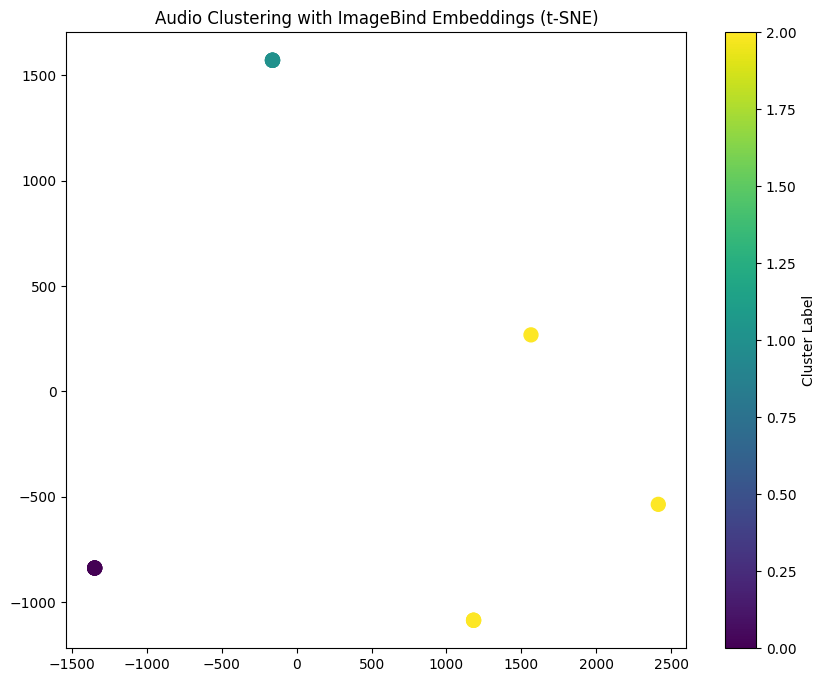

In [10]:
tsne = TSNE(n_components=2, perplexity=5, random_state=17)
embeddings_2d = tsne.fit_transform(audio_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=pred_labels, cmap='viridis', s=100)
plt.title('Audio Clustering with ImageBind Embeddings (t-SNE)')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

## 6. Evaluation
Compare with ground truth labels.

In [11]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(labels, pred_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 1.0000
